In [1]:
import requests
import csv
from datetime import datetime, timedelta, timezone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
symbols = [ 'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BNBUSDT', 'SOLUSDT']

In [ ]:
start_time = datetime(2021, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, tzinfo=timezone.utc)

# Binance API 端點
base_url = 'https://fapi.binance.com'

# 設定每次請求的條數
limit = 1000

for symbol in symbols:
    current_start_time = start_time
    csv_filename = f'{symbol}_15m_klines.csv'

    with open(csv_filename, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])  # 新增 Volume 欄位

        while current_start_time < end_time:
            endpoint = f'/fapi/v1/klines'
            params = {
                'symbol': symbol,
                'interval': '15m',
                'startTime': int(current_start_time.timestamp()) * 1000,
                'limit': limit
            }

            response = requests.get(base_url + endpoint, params=params)
            kline_data = response.json()

            if not kline_data:
                break  

            
            for kline in kline_data:
                timestamp = datetime.utcfromtimestamp(kline[0] / 1000).replace(tzinfo=timezone.utc)
                open_price = float(kline[1])
                high_price = float(kline[2])
                low_price = float(kline[3])
                close_price = float(kline[4])
                volume = float(kline[5])  

                csv_writer.writerow([timestamp, open_price, high_price, low_price, close_price, volume])

            
            current_start_time = datetime.utcfromtimestamp(kline_data[-1][0] / 1000).replace(tzinfo=timezone.utc) + timedelta(minutes=15)

    print(f'{csv_filename} 已建立')

Successfully processed BTCUSDT_15m_klines.csv
Successfully processed ETHUSDT_15m_klines.csv
Successfully processed XRPUSDT_15m_klines.csv
Successfully processed BNBUSDT_15m_klines.csv
Successfully processed SOLUSDT_15m_klines.csv


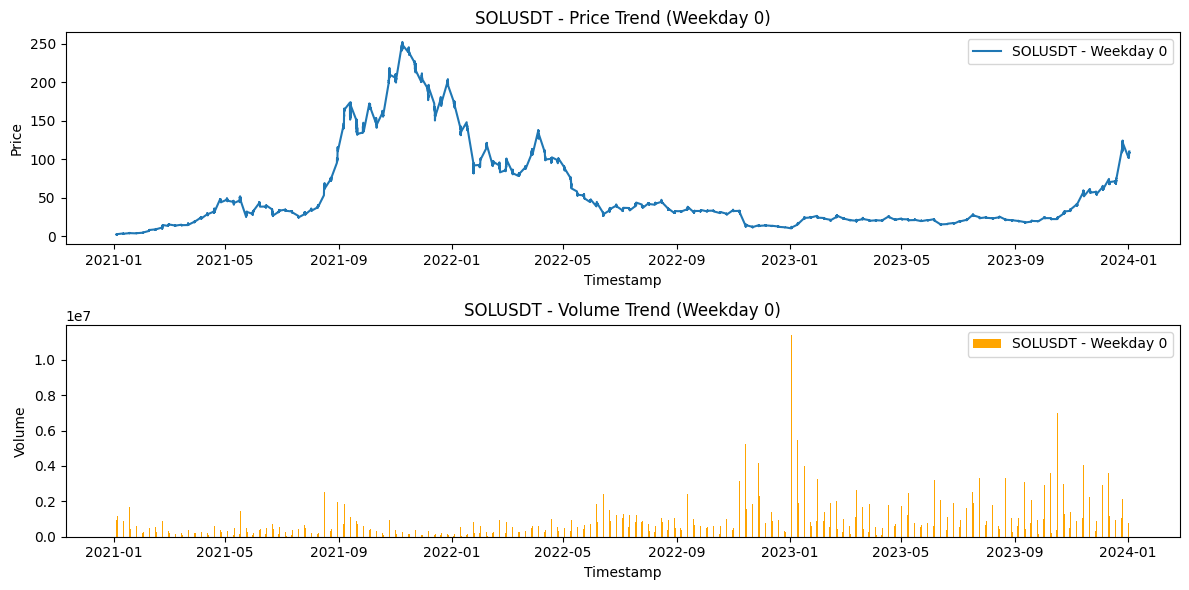

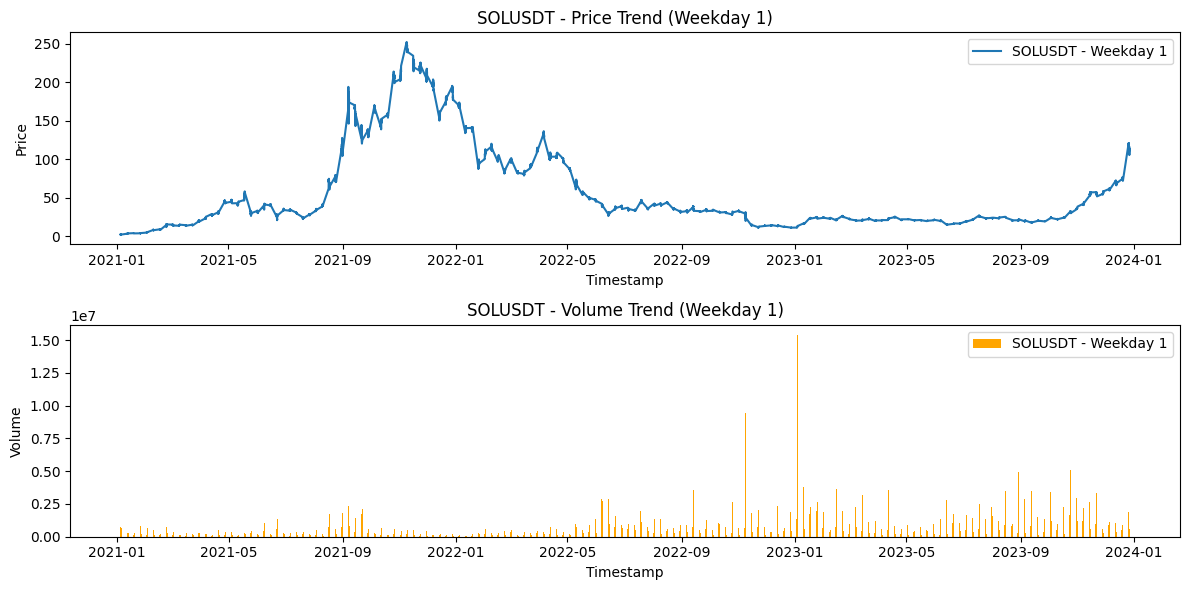

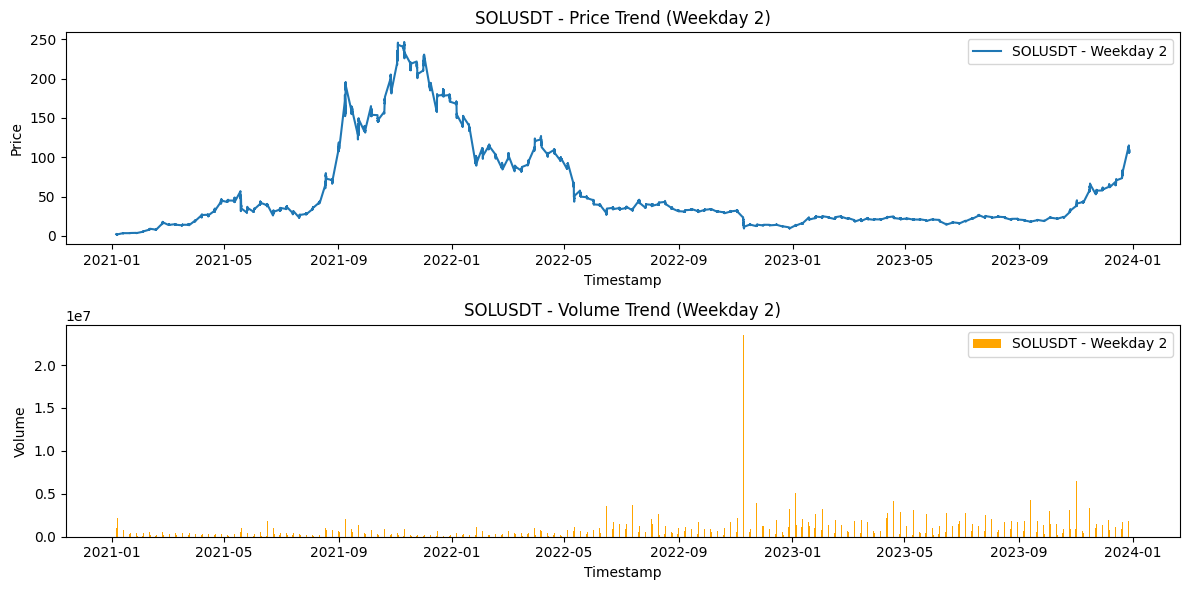

In [7]:
for symbol in symbols:
    csv_filename = f'{symbol}_15m_klines.csv'
    
    try:
        df = pd.read_csv(csv_filename, parse_dates=['Timestamp'])
        df['Weekday'] = df['Timestamp'].dt.dayofweek
        weekdays = [0, 1, 2]
        
        print(f"Successfully processed {csv_filename}")
    except FileNotFoundError:
        print(f"File not found: {csv_filename}")
    except Exception as e:
        print(f"An error occurred while processing {csv_filename}: {e}") 

for day in weekdays:
    subset = df[df['Weekday'] == day]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(subset['Timestamp'], subset['Close'], label=f'{symbol} - Weekday {day}')
    plt.title(f'{symbol} - Price Trend (Weekday {day})')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(subset['Timestamp'], subset['Volume'], label=f'{symbol} - Weekday {day}', color='orange')
    plt.title(f'{symbol} - Volume Trend (Weekday {day})')
    plt.xlabel('Timestamp')
    plt.ylabel('Volume')
    plt.legend()

    plt.tight_layout()
    plt.show()

計算日報酬

BTCUSDT_daily_return.csv 已建立
ETHUSDT_daily_return.csv 已建立
XRPUSDT_daily_return.csv 已建立
BNBUSDT_daily_return.csv 已建立
SOLUSDT_daily_return.csv 已建立


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

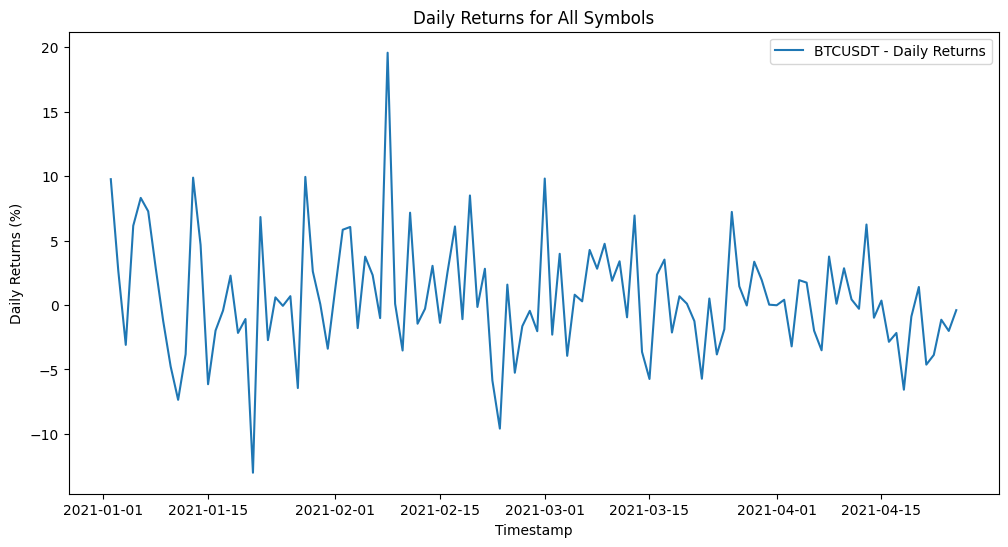

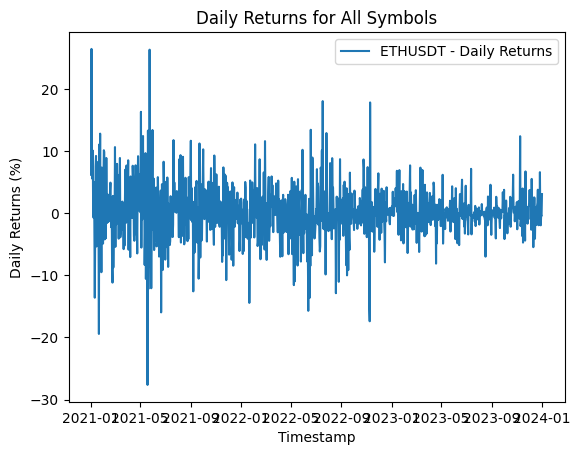

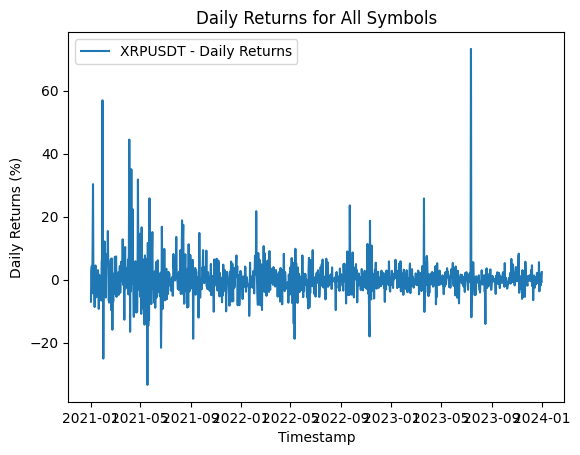

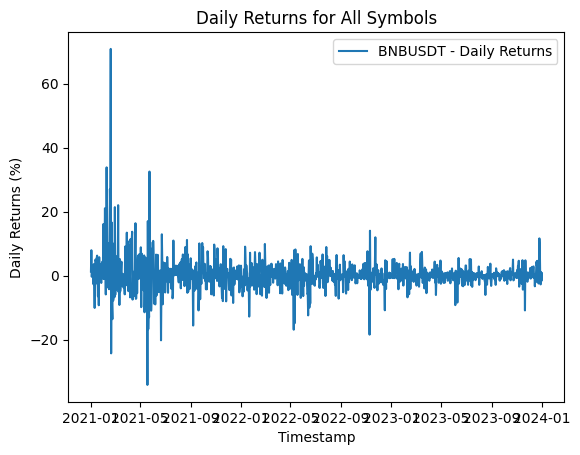

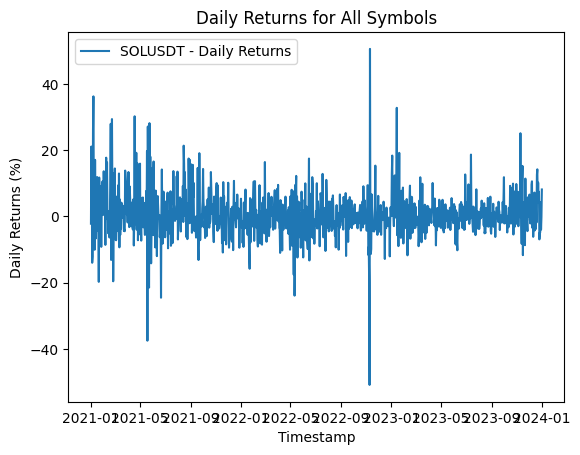

In [20]:
all_data = pd.DataFrame()

for symbol in symbols:
    csv_filename = f'{symbol}_15m_klines.csv'
    df = pd.read_csv(csv_filename, parse_dates=['Timestamp'])

    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    df_daily[f'{symbol}_Daily_Return'] = df_daily['Close'].pct_change() * 100  # Percentage change in closing price

    return_csv_filename = f'{symbol}_daily_return.csv'
    df_daily[['Close', f'{symbol}_Daily_Return']].to_csv(return_csv_filename, index=True)
    print(f'{return_csv_filename} 已建立')

    all_data = pd.concat([all_data, df_daily[[f'{symbol}_Daily_Return']]], axis=1)
    plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(all_data.index, all_data[f'{symbol}_Daily_Return'], label=f'{symbol} - Daily Returns')

    plt.title('Daily Returns for All Symbols')
    plt.xlabel('Timestamp')
    plt.ylabel('Daily Returns (%)')
    plt.legend()
    plt.show()

相對動能投資組合

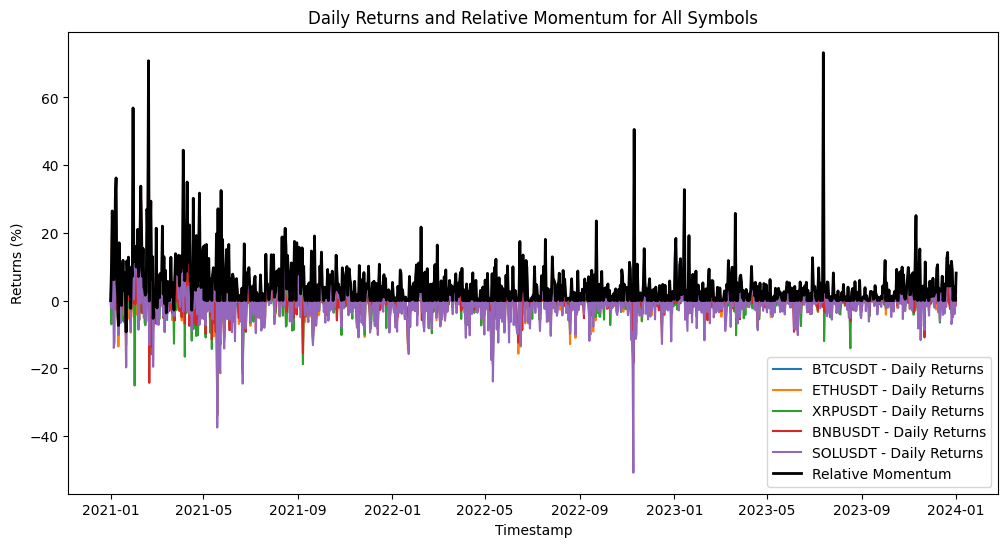

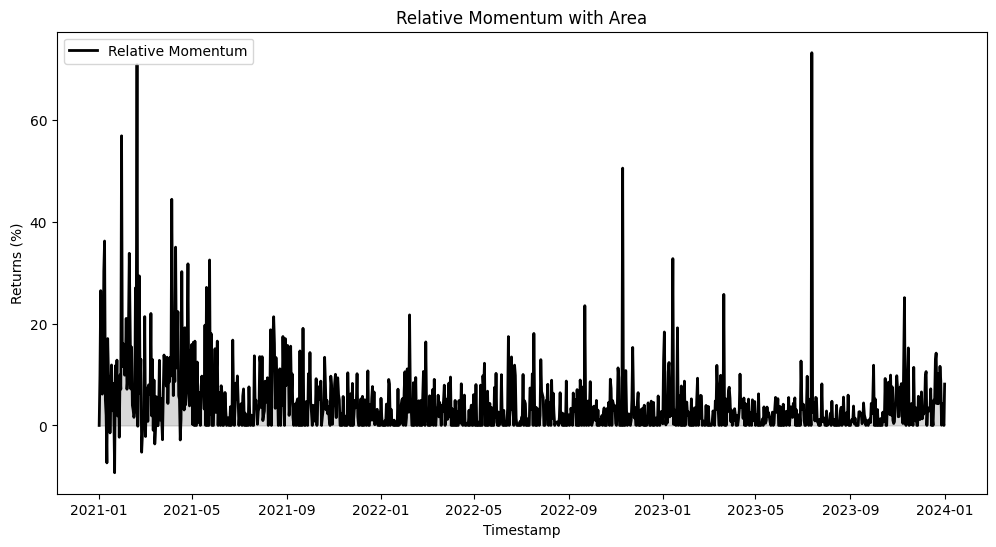

In [21]:

all_data.fillna(0, inplace=True)


all_data['Relative_Momentum'] = all_data.apply(lambda row: row[row.idxmax(skipna=True)], axis=1)

# Plot combined daily returns and relative momentum
plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(all_data.index, all_data[f'{symbol}_Daily_Return'], label=f'{symbol} - Daily Returns')

plt.plot(all_data.index, all_data['Relative_Momentum'], label='Relative Momentum', color='black', linewidth=2)

plt.title('Daily Returns and Relative Momentum for All Symbols')
plt.xlabel('Timestamp')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()

# Plot relative momentum with filled area
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['Relative_Momentum'], label='Relative Momentum', color='black', linewidth=2)
plt.fill_between(all_data.index, 0, all_data['Relative_Momentum'], color='gray', alpha=0.3)  # Fill area under the curve

plt.title('Relative Momentum with Area')
plt.xlabel('Timestamp')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()

equal weight

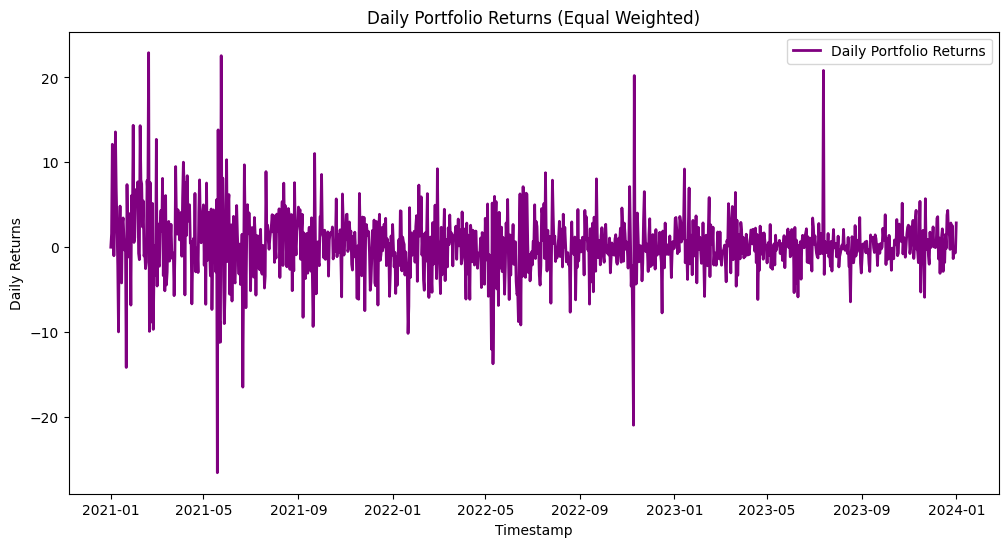

In [22]:
# Calculate daily portfolio returns (equal-weighted)
df_daily_portfolio_returns = all_data.filter(like='_Daily_Return').mean(axis=1)

# Plot daily portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(df_daily_portfolio_returns.index, df_daily_portfolio_returns, label='Daily Portfolio Returns', color='purple', linewidth=2)

plt.title('Daily Portfolio Returns (Equal Weighted)')
plt.xlabel('Timestamp')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

投資組合績效比較

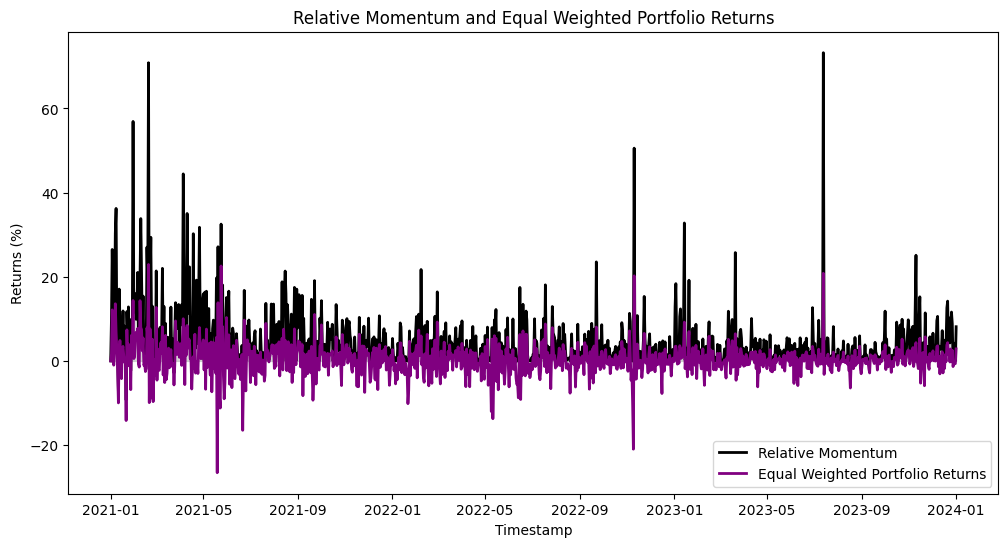

In [23]:
# Plot relative momentum and equal-weighted portfolio returns on the same graph
plt.figure(figsize=(12, 6))

# Plot relative momentum
plt.plot(all_data.index, all_data['Relative_Momentum'], label='Relative Momentum', color='black', linewidth=2)
plt.fill_between(all_data.index, 0, all_data['Relative_Momentum'], color='gray', alpha=0.3)  # Fill area under the curve

# Plot equal-weighted portfolio returns
plt.plot(df_daily_portfolio_returns.index, df_daily_portfolio_returns, label='Equal Weighted Portfolio Returns', color='purple', linewidth=2)

plt.title('Relative Momentum and Equal Weighted Portfolio Returns')
plt.xlabel('Timestamp')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()